In [ ]:
!pip install -q gdown torchmetrics lpips torch-fidelity tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.5 MB/s eta 0:00:00


In [ ]:
# getting the zero-Dce repo cloned
!gdown 1m5dd3hd51p-EDHj05Pqsgspoiy5Gs6f_ # LAMA 36500 IMGS
!gdown 14-0t8X0pZBv_tyhs-PxNISdokKqO-aUN # MASKS 36500 IMGS
!gdown 1kUMW5pec4JVR0AKMkH49aoIOTGnnPmuP #MAT 17091 IMGS
!gdown 1bnwMgFjF_TTZecNZc5BhizSFsLQWF2w0 # LAMA DENOISER MODE 1500 IMGS AND 10 EPOCHS
!gdown 1nMO_cpStojAj3EZozum__RufVdPFvIZF # UNET MODEL WITH 1500 IMGS (TRAIN) AND 10 EPOCHS
!gdown 15_7PCeCS1IksoffCF1TNiZq-6mxqaObk # FINAL DENOISER MODEL WITH 1500 IMGS (TRAIN) AND 10 EPOCHS

Downloading...
From (original): https://drive.google.com/uc?id=1m5dd3hd51p-EDHj05Pqsgspoiy5Gs6f_
From (redirected): https://drive.google.com/uc?id=1m5dd3hd51p-EDHj05Pqsgspoiy5Gs6f_&confirm=t&uuid=958f37f3-5d35-4845-b84c-907d693f59e4
To: /content/lama_imgs_36500.zip
100% 548M/548M [00:14<00:00, 36.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=14-0t8X0pZBv_tyhs-PxNISdokKqO-aUN
From (redirected): https://drive.google.com/uc?id=14-0t8X0pZBv_tyhs-PxNISdokKqO-aUN&confirm=t&uuid=c69eab33-80bb-47d5-b998-b9a1b9fa8675
To: /content/masks (1).zip
100% 62.6M/62.6M [00:02<00:00, 22.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1kUMW5pec4JVR0AKMkH49aoIOTGnnPmuP
From (redirected): https://drive.google.com/uc?id=1kUMW5pec4JVR0AKMkH49aoIOTGnnPmuP&confirm=t&uuid=04374452-979e-4232-8500-34dd4d5b7bd8
To: /content/mat_imgs_17091.zip
100% 1.33G/1.33G [00:27<00:00, 48.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1bnwMgFjF_TTZecNZc5BhizSFsLQWF2w0
To

In [ ]:
#making the unzip function
import zipfile
import os

def unzip_file(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f'Extracted all files to {extract_to}')

In [ ]:
#usng the unzip function
unzip_file("lama_imgs_36500.zip", "neww")
unzip_file("masks.zip", "neww")
unzip_file("mat_imgs_17091.zip", "neww")

Extracted all files to neww
Extracted all files to neww
Extracted all files to neww


In [ ]:
# downloading the dataset
import torchvision

train = torchvision.datasets.Places365(root = "data/", split = 'val', small = True, download = True )
train

100%|██████████| 67498496/67498496 [00:02<00:00, 31494316.27it/s]


Extracting data/filelist_places365-standard.tar to data/


100%|██████████| 525158400/525158400 [00:12<00:00, 40746446.61it/s]


Extracting data/val_256.tar to data/


Dataset Places365
    Number of datapoints: 36500
    Root location: data/
    Split: val
    Small: True

In [ ]:
# reoving the wrong files
from pathlib import Path
import os
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

path = Path("data/val_256/")

# if we will use train data then it would have folders many of diff objects while in validation set there is no such complicaion
# removing the improper images
count = 0
for i in os.listdir(path):
  img = plt.imread(path/i)
  if img.shape[-1] != 3:
    os.remove(path/i)
    count += 1

print(f"Deleted images with incorrect number of dims : {count}")

Deleted images with incorrect number of dims : 79


In [ ]:
# checking the number of each imgs
from pathlib import Path
import pandas as pd

path0 = Path("data/val_256/")
path = Path("neww/masks")
path2 = Path("neww/out_path_rg")
path3 = Path("neww/test_images")

l0 = list(path0.glob("*.jpg"))
l1 = list(path.glob("*.jpg"))
l2 = list(path2.glob("*.png"))
l3 = list(path3.glob("*.jpg"))

l0.sort()
l1.sort()
l2.sort()
l3.sort()
print(len(l0),len(l1), len(l2), len(l3))

36421 36421 17055 36421


In [ ]:
# the custom dataset function
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2
class inpainting_dataset(Dataset):
  """
  The path must be a PAthLib Path object
  """
  def __init__(self, path, transform = None, split : str = "train"):
    self.path = path
    self.transform = transform
    self.imgs =  list(self.path.glob("*.jpg"))

    self.path = Path("neww/test_images")
    self.lama_imgs = list(self.path.glob("*.jpg"))

    self.path = Path("neww/out_path_rg")
    self.mat_imgs = list(self.path.glob("*.png"))

    self.path = Path("neww/masks/")
    self.masks = list(self.path.glob("*.jpg"))

    self.final = []
    for i in self.imgs:
      name = i.as_posix().split("/")[-1].split(".")[0]
      mat_name = "neww/out_path_rg/" + name + ".png"    # for mat we have png format
      lama_name = "neww/test_images/" + name + ".jpg" # for lama we have jpg format
      mask_name = "neww/masks/" + name + ".jpg" # for masks

      if os.path.exists(mat_name) and os.path.exists(lama_name) and os.path.exists(mask_name):
        self.final.append(name)

      self.imgs = self.final

    # self.train_imgs, self.val_imgs = train_test_split(self.final, test_size = 0.3,random_state = 42)
    # if split == "train":
    #   self.imgs = self.train_imgs
    # else:
    #   self.imgs = self.val_imgs

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx): # self.final have onlyu names which will be used to just make the path of imgs
    name = self.imgs[idx]  # to get the path only

    img_n = "data/val_256/" + name + ".jpg"  # for image name
    mat = "neww/out_path_rg/" + name + ".png"    # for mat we have png format
    lama = "neww/test_images/" + name + ".jpg" # for lama we have jpg format
    mask = "neww/masks/" + name + ".jpg" # for masks

    img = cv2.imread(img_n)
    img_lama = torch.tensor(cv2.imread(lama))
    mat_img = cv2.imread(mat)

    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    _, binary_mk = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    inv_mask = cv2.bitwise_not(binary_mk)

    img_back = cv2.bitwise_and(img, img, mask=inv_mask)
    img_fg = cv2.bitwise_and(mat_img, mat_img, mask=binary_mk)

    final_mat_img = img_back + img_fg

    return torch.tensor(img), img_lama, torch.tensor(final_mat_img) #i.e. correct image, lama and mat image

In [ ]:
path = Path("data/val_256/")

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])

In [ ]:
# making the train and test dataset
train_dataset = inpainting_dataset(path, transform = transform, split = "train")
test_dataset = inpainting_dataset(path, transform = transform, split = "test")
train_dataset, test_dataset

(<__main__.inpainting_dataset at 0x79543ecbd840>,
 <__main__.inpainting_dataset at 0x79543ecbc640>)

In [ ]:
dataset = inpainting_dataset(path, transform = transform)
dataset

In [ ]:
dataloader = DataLoader(dataset, batch_size = 16,shuffle = False)
dataloader

In [ ]:
# making the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 16,shuffle = False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79543ecbe1a0>,
 <torch.utils.data.dataloader.DataLoader at 0x79543ecbd960>)

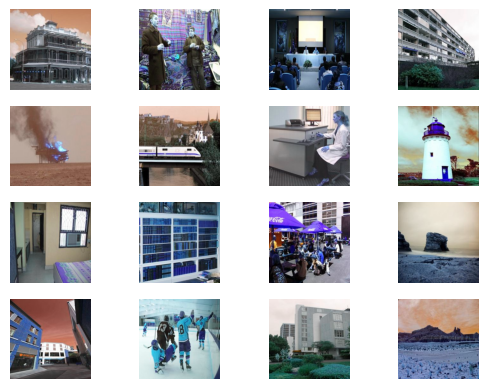

In [ ]:
# exploringg some data
z = next(iter(dataloader))

for i in range (16):
  plt.subplot(4,4,i+1)
  plt.axis("off")
  plt.imshow(z[2][i].detach().numpy())

In [ ]:
len(dataloader) * 16

17056

In [ ]:
# the ensemble model --- PLAIN ONE
import torch
from torch import nn

class EnsembleModel(nn.Module):
  """
  This model will combine the output MAT and LAMA which will be saved in the model folder
  """
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, 3, 1, 1),
        nn.LeakyReLU(),
        # nn.MaxPool2d(2),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(3, 32, 3, 1, 1),
        nn.LeakyReLU(),
        # nn.MaxPool2d(2),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),
        # nn.MaxPool2d(2),
    )

    self.in_conv3 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),

        nn.ConvTranspose2d(64, 32, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),

        nn.ConvTranspose2d(32, 3, 3, 1, 1),   # dependednt on output of concatenation
        nn.LeakyReLU(),
    )


  def forward(self, img1, img2):
    x = self.conv1(img1)
    y = self.conv2(img2)
    z = torch.cat((x, y), dim=1)
    z = self.conv3(z)
    z = self.in_conv3(z)
    return z


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        # self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        # self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 3, stride=1)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 3, stride=1)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 3, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        # x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        # x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        # x = self.pool(x)  # compressed representation

        ## decode ##
        # add transpose conv layers, with relu activation function
        # x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))

        return x

denoise = ConvDenoiser()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Conv layer (3 --> 32 channels)
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)  # Conv layer (32 --> 16 channels)
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)  # Conv layer (16 --> 8 channels)

        ## decoder layers ##
        # Transpose layers to upsample back to the original input size
        self.t_conv1 = nn.ConvTranspose2d(8, 16, 3, padding=1)  # upsample by stride 1, no change in spatial dim
        self.t_conv2 = nn.ConvTranspose2d(16, 32, 3, padding=1)  # upsample by stride 1, no change in spatial dim
        self.t_conv3 = nn.ConvTranspose2d(32, 3, 3, padding=1)  # Output back to 3 channels

    def forward(self, x):
        ## encode ##
        x = F.leaky_relu(self.conv1(x))  # First conv layer
        x = F.leaky_relu(self.conv2(x))  # Second conv layer
        x = F.leaky_relu(self.conv3(x))  # Third conv layer

        ## decode ##
        x = F.leaky_relu(self.t_conv1(x))  # First transpose conv
        x = F.leaky_relu(self.t_conv2(x))  # Second transpose conv
        x = torch.sigmoid(self.t_conv3(x))  # Output layer with sigmoid activation

        return x

# Instantiate the model
denoise = ConvDenoiser()


In [ ]:
!pip install -q torchinfo

In [ ]:
from torchinfo import summary
import torch
# Create an input tensor with the correct dimensions
input_tensor = torch.randn(16, 3, 256, 256)

# Pass the input tensor to denoise()
out = denoise(input_tensor)
out.shape

torch.Size([16, 3, 256, 256])

In [ ]:
# the loss function utility
import os
import torch
from collections import OrderedDict
from torch import nn as nn
from torchvision.models import vgg as vgg

class Registry():
    """
    The registry that provides name -> object mapping, to support third-party
    users' custom modules.

    To create a registry (e.g. a backbone registry):

    .. code-block:: python

        BACKBONE_REGISTRY = Registry('BACKBONE')

    To register an object:

    .. code-block:: python

        @BACKBONE_REGISTRY.register()
        class MyBackbone():
            ...

    Or:

    .. code-block:: python

        BACKBONE_REGISTRY.register(MyBackbone)
    """

    def __init__(self, name):
        """
        Args:
            name (str): the name of this registry
        """
        self._name = name
        self._obj_map = {}

    def _do_register(self, name, obj):
        assert (name not in self._obj_map), (f"An object named '{name}' was already registered "
                                             f"in '{self._name}' registry!")
        self._obj_map[name] = obj

    def register(self, obj=None):
        """
        Register the given object under the the name `obj.__name__`.
        Can be used as either a decorator or not.
        See docstring of this class for usage.
        """
        if obj is None:
            # used as a decorator
            def deco(func_or_class):
                name = func_or_class.__name__
                self._do_register(name, func_or_class)
                return func_or_class

            return deco

        # used as a function call
        name = obj.__name__
        self._do_register(name, obj)

    def get(self, name):
        ret = self._obj_map.get(name)
        if ret is None:
            raise KeyError(f"No object named '{name}' found in '{self._name}' registry!")
        return ret

    def __contains__(self, name):
        return name in self._obj_map

    def __iter__(self):
        return iter(self._obj_map.items())

    def keys(self):
        return self._obj_map.keys()


DATASET_REGISTRY = Registry('dataset')
ARCH_REGISTRY = Registry('arch')
MODEL_REGISTRY = Registry('model')
LOSS_REGISTRY = Registry('loss')
METRIC_REGISTRY = Registry('metric')

VGG_PRETRAIN_PATH = 'experiments/pretrained_models/vgg19-dcbb9e9d.pth'
NAMES = {
    'vgg11': [
        'conv1_1', 'relu1_1', 'pool1', 'conv2_1', 'relu2_1', 'pool2', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2',
        'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2',
        'pool5'
    ],
    'vgg13': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'pool4',
        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'pool5'
    ],
    'vgg16': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'pool3', 'conv4_1', 'relu4_1', 'conv4_2',
        'relu4_2', 'conv4_3', 'relu4_3', 'pool4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3',
        'pool5'
    ],
    'vgg19': [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'pool3', 'conv4_1',
        'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'pool4', 'conv5_1', 'relu5_1',
        'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'pool5'
    ]
}


def insert_bn(names):
    """Insert bn layer after each conv.

    Args:
        names (list): The list of layer names.

    Returns:
        list: The list of layer names with bn layers.
    """
    names_bn = []
    for name in names:
        names_bn.append(name)
        if 'conv' in name:
            position = name.replace('conv', '')
            names_bn.append('bn' + position)
    return names_bn


@ARCH_REGISTRY.register()
class VGGFeatureExtractor(nn.Module):
    """VGG network for feature extraction.

    In this implementation, we allow users to choose whether use normalization
    in the input feature and the type of vgg network. Note that the pretrained
    path must fit the vgg type.

    Args:
        layer_name_list (list[str]): Forward function returns the corresponding
            features according to the layer_name_list.
            Example: {'relu1_1', 'relu2_1', 'relu3_1'}.
        vgg_type (str): Set the type of vgg network. Default: 'vgg19'.
        use_input_norm (bool): If True, normalize the input image. Importantly,
            the input feature must in the range [0, 1]. Default: True.
        range_norm (bool): If True, norm images with range [-1, 1] to [0, 1].
            Default: False.
        requires_grad (bool): If true, the parameters of VGG network will be
            optimized. Default: False.
        remove_pooling (bool): If true, the max pooling operations in VGG net
            will be removed. Default: False.
        pooling_stride (int): The stride of max pooling operation. Default: 2.
    """

    def __init__(self,
                 layer_name_list,
                 vgg_type='vgg19',
                 use_input_norm=True,
                 range_norm=False,
                 requires_grad=False,
                 remove_pooling=False,
                 pooling_stride=2):
        super(VGGFeatureExtractor, self).__init__()

        self.layer_name_list = layer_name_list
        self.use_input_norm = use_input_norm
        self.range_norm = range_norm

        self.names = NAMES[vgg_type.replace('_bn', '')]
        if 'bn' in vgg_type:
            self.names = insert_bn(self.names)

        # only borrow layers that will be used to avoid unused params
        max_idx = 0
        for v in layer_name_list:
            idx = self.names.index(v)
            if idx > max_idx:
                max_idx = idx

        if os.path.exists(VGG_PRETRAIN_PATH):
            vgg_net = getattr(vgg, vgg_type)(pretrained=False)
            state_dict = torch.load(VGG_PRETRAIN_PATH, map_location=lambda storage, loc: storage)
            vgg_net.load_state_dict(state_dict)
        else:
            vgg_net = getattr(vgg, vgg_type)(pretrained=True)

        features = vgg_net.features[:max_idx + 1]

        modified_net = OrderedDict()
        for k, v in zip(self.names, features):
            if 'pool' in k:
                # if remove_pooling is true, pooling operation will be removed
                if remove_pooling:
                    continue
                else:
                    # in some cases, we may want to change the default stride
                    modified_net[k] = nn.MaxPool2d(kernel_size=2, stride=pooling_stride)
            else:
                modified_net[k] = v

        self.vgg_net = nn.Sequential(modified_net).to(device)

        if not requires_grad:
            self.vgg_net.eval()
            for param in self.parameters():
                param.requires_grad = False
        else:
            self.vgg_net.train()
            for param in self.parameters():
                param.requires_grad = True

        if self.use_input_norm:
            # the mean is for image with range [0, 1]
            self.register_buffer('mean', torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device))
            # the std is for image with range [0, 1]
            self.register_buffer('std', torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device))

    def forward(self, x):
        """Forward function.

        Args:
            x (Tensor): Input tensor with shape (n, c, h, w).

        Returns:
            Tensor: Forward results.
        """
        if self.range_norm:
            x = (x + 1) / 2
        if self.use_input_norm:
            x = (x - self.mean) / self.std
        output = {}

        for key, layer in self.vgg_net._modules.items():
            x = layer(x)
            if key in self.layer_name_list:
                output[key] = x.clone()

        return output

In [ ]:
# actual loss function
import torch.nn.functional as F

class StyleLoss(nn.Module):

    def __init__(self):
        super(StyleLoss, self).__init__()

    def gram_matrix(self,input):
      a, b, c, d = input.size()  # a=batch size(=1)
      # b=number of feature maps
      # (c,d)=dimensions of a f. map (N=c*d)

      features = input.contiguous().view(a * b, c * d)  # resize F_XL into \hat F_XL

      G = torch.mm(features, features.t())  # compute the gram product

      # we 'normalize' the values of the gram matrix
      # by dividing by the number of element in each feature maps.
      return G.div(a * b * c * d)

    def forward(self, input, target1):
        G = self.gram_matrix(input)
        target = self.gram_matrix(target1).detach()
        self.loss = F.mse_loss(G, target)
        return self.loss

class PerceptualLoss(nn.Module):
    """Perceptual loss with commonly used style loss.

    Args:
        layer_weights (dict): The weight for each layer of vgg feature.
            Here is an example: {'conv5_4': 1.}, which means the conv5_4
            feature layer (before relu5_4) will be extracted with weight
            1.0 in calculting losses.
        vgg_type (str): The type of vgg network used as feature extractor.
            Default: 'vgg19'.
        use_input_norm (bool):  If True, normalize the input image in vgg.
            Default: True.
        range_norm (bool): If True, norm images with range [-1, 1] to [0, 1].
            Default: False.
      """

    def __init__(self,
                 layer_weights = {'conv1_2': 1, 'conv2_2': 1,'conv3_4': 1,'conv4_4': 1},
                 vgg_type='vgg19',
                 use_input_norm=True,
                 range_norm=True):
        super(PerceptualLoss, self).__init__()
        self.layer_weights = layer_weights
        self.vgg = VGGFeatureExtractor(
            layer_name_list=list(self.layer_weights.keys()),
            vgg_type=vgg_type,
            use_input_norm=use_input_norm,
            range_norm=range_norm)

        self.criterion = torch.nn.L1Loss()

    def forward(self, x, gt):
        """Forward function.

        Args:
            x (Tensor): Input tensor with shape (n, c, h, w).
            gt (Tensor): Ground-truth tensor with shape (n, c, h, w).

        Returns:
            Tensor: Forward results.
        """
        # extract vgg features
        x_features = self.vgg(x)
        gt_features = self.vgg(gt.detach())

        # calculate perceptual loss
        percep_loss = 0
        for k in x_features.keys():
            percep_loss += self.criterion(x_features[k], gt_features[k]) * self.layer_weights[k]

        return percep_loss


# def l1_loss():   -> take direct from premade
#   pass

class EdgeLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(EdgeLoss, self).__init__()
        k = torch.Tensor([[.05, .25, .4, .25, .05]])
        self.kernel = torch.matmul(k.t(),k).unsqueeze(0).repeat(3,1,1,1).to(device)

    def conv_gauss(self, img):
        n_channels, _, kw, kh = self.kernel.shape
        img = F.pad(img, (kw//2, kh//2, kw//2, kh//2), mode='replicate')
        return F.conv2d(img, self.kernel, groups=n_channels)

    def laplacian_kernel(self, current):
        filtered    = self.conv_gauss(current)
        down        = filtered[:,:,::2,::2]
        new_filter  = torch.zeros_like(filtered)
        new_filter[:,:,::2,::2] = down*4
        filtered    = self.conv_gauss(new_filter)
        diff = current - filtered
        return diff

    def forward(self, x, y):
        loss = F.mse_loss(self.laplacian_kernel(x), self.laplacian_kernel(y))
        return loss

class CombinedLoss(nn.Module):
    def __init__(self, device = "cpu"):
        super(CombinedLoss, self).__init__()
        self.edge_loss = EdgeLoss().to(device)
        self.mse_loss = nn.MSELoss().to(device)  # l1 loss
        self.style_loss = StyleLoss().to(device)
        self.perceptual_loss = PerceptualLoss().to(device)

    def forward(self, gen_img, gt_img):
        gen_img.to(device)
        gt_img.to(device)
        edge_loss_value = self.edge_loss(gen_img, gt_img)
        mse_loss_value = self.mse_loss(gen_img, gt_img)
        style_loss_value = self.style_loss(gen_img, gt_img)
        perceptual_loss_value = self.perceptual_loss(gen_img, gt_img)
        total_loss = edge_loss_value + mse_loss_value + style_loss_value + perceptual_loss_value
        return total_loss


#Training the denoising model

In [ ]:
# initialize the NN
denoising_model = ConvDenoiser()
criterion = nn.MSELoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

# specify loss function
denoising_optimizer = torch.optim.Adam(denoising_model.parameters(), lr=0.001)

In [ ]:
# actual training
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm

NUM_EPOCHS = 5

denoising_model.to(device)

print(type(denoising_model))
for epoch in tqdm(range(NUM_EPOCHS)):
  train_loss = 0
  denoising_model.train()
  for num,(img, lama, mat) in tqdm(enumerate(train_dataloader)):
    img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)

    pred = denoising_model(lama)

    loss = criterion(pred, img/255.0)  # for RGB color space
    train_loss += loss.item()

    denoising_optimizer.zero_grad()
    loss.backward()
    denoising_optimizer.step()

  test_loss = 0
  denoising_model.eval()
  with torch.inference_mode():
    for num ,(img, lama, mat) in tqdm(enumerate(test_dataloader)):
      img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)

      pred = denoising_model(lama)
      loss = criterion(pred, img/255.0)

      test_loss += loss.item()

  test_loss /= len(test_dataloader)
  train_loss /= len(train_dataloader)

  if epoch%1 == 0:
    torch.save(denoising_model, f"denoising_model_epoch_{epoch}.pth")
    print(f'\nepoch : {epoch} || train loss : {train_loss} || test loss : {test_loss}')

<class '__main__.ConvDenoiser'>


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 0 || train loss : 0.020577056367495437 || test loss : 0.010528662432493134


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 1 || train loss : 0.011211578879596257 || test loss : 0.009880687766285106


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 2 || train loss : 0.010763512090666266 || test loss : 0.009668546485375951


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 3 || train loss : 0.01056875723027965 || test loss : 0.010054153570143337


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 4 || train loss : 0.010307887430507236 || test loss : 0.009554035173178736


# training the denoising model on output of ensembler


In [ ]:
print("hlo")

hlo


In [ ]:
# training hyperparams
from torch.optim import Adam
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = EnsembleModel()
model = torch.load("best_unet_with_denois.pth").to(device)
model.to(device)

denoising_model = ConvDenoiser()
denoising_model_lama = torch.load("denoising_model_good.pth")

loss_fn = nn.MSELoss()

denoising_optimizer = torch.optim.Adam(denoising_model.parameters(), lr=0.001)

<ipython-input-51-b8b79b75c2a3>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("best_unet_with_denois.pth").to(device)
<ipython-input-51-b8b79b75c2a3>:1

In [ ]:
# actual training
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm

NUM_EPOCHS = 5

model.to(device)
denoising_model.to(device)
denoising_model_lama.to(device)

model.eval()
denoising_model_lama.eval()

print(type(denoising_model))
for epoch in tqdm(range(NUM_EPOCHS)):
  train_loss = 0
  denoising_model.train()
  for num,(img, lama, mat) in tqdm(enumerate(train_dataloader)):
    img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)

    pred = denoising_model(model(denoising_model_lama(lama), mat))

    loss = loss_fn(pred*255.0, img)  # for RGB color space
    train_loss += loss.item()

    denoising_optimizer.zero_grad()
    loss.backward()
    denoising_optimizer.step()

  test_loss = 0
  denoising_model.eval()
  with torch.inference_mode():
    for num ,(img, lama, mat) in tqdm(enumerate(test_dataloader)):
      img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)

      pred = denoising_model(model(denoising_model_lama(lama), mat))
      loss = loss_fn(pred*255.0, img)

      test_loss += loss.item()

  test_loss /= len(test_dataloader)
  train_loss /= len(train_dataloader)

  if epoch%1 == 0:
    torch.save(model, f"model_epoch_{epoch}.pth")
    print(f'\nepoch : {epoch} || train loss : {train_loss} || test loss : {test_loss}')

<class '__main__.ConvDenoiser'>


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 0 || train loss : 61.30586110556998 || test loss : 111.45435853437944


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 1 || train loss : 59.68726345155297 || test loss : 54.77767866308039


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 2 || train loss : 55.165857817487016 || test loss : 54.85136738690463


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 3 || train loss : 46.866142021737446 || test loss : 45.652615157040685


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 4 || train loss : 42.2803336166754 || test loss : 40.065861615267664


In [ ]:
torch.save(denoising_model, 'best_denoising_model_for_final_mf.pth')

# Training the ensemble model

In [ ]:
! pip install pytorch_ssim

  Preparing metadata (setup.py) ... done
  Created wheel for pytorch_ssim: filename=pytorch_ssim-0.1-py3-none-any.whl size=2007 sha256=829fe915f711f02bae563518d120b32d547ff087f922c29be9e11f2e515bf846
  Stored in directory: /root/.cache/pip/wheels/2e/0c/10/4a3f91bd610b23196f1e28f8af80b3ec86786b50f3e86dc21e
Successfully built pytorch_ssim


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, size_average=True):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1  # Can be changed if you're using color images (e.g. 3 for RGB)
        self.window = self.create_window(window_size, self.channel)

    def gaussian_window(self, window_size, sigma):
        gauss = torch.Tensor([np.exp(-(x - window_size//2)**2 / float(2 * sigma**2)) for x in range(window_size)])
        return gauss / gauss.sum()

    def create_window(self, window_size, channel):
        _1D_window = self.gaussian_window(window_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
        return window

    def _ssim(self, img1, img2, window, window_size, channel, size_average=True):
        mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)
        mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)

        mu1_sq = mu1 ** 2
        mu2_sq = mu2 ** 2
        mu1_mu2 = mu1 * mu2

        sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size//2, groups=channel) - mu1_sq
        sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size//2, groups=channel) - mu2_sq
        sigma12 = F.conv2d(img1 * img2, window, padding=window_size//2, groups=channel) - mu1_mu2

        C1 = 0.01 ** 2
        C2 = 0.03 ** 2

        ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

        if size_average:
            return ssim_map.mean()
        else:
            return ssim_map.mean(1).mean(1).mean(1)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = self.create_window(self.window_size, channel)

            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)

            self.channel = channel
            self.window = window

        return 1 - self._ssim(img1, img2, window, self.window_size, channel, self.size_average)


# Example Usage:
# Create an instance of the SSIM loss
ssim_loss = SSIMLoss(window_size=11, size_average=True)

# Dummy input tensors (for example, your model output and ground truth image)

z = next(iter(test_dataloader))
ground_truth, lama, mat = z[0][1], z[1][1], z[2][1]

output = model(denoising_model(lama.unsqueeze(0).to(torch.float).permute(0,3,1,2)), mat.unsqueeze(0).to(torch.float).permute(0,3,1,2)).squeeze()

# output = model(denoising_model(lama), mat)  # Example shape: (batch_size, channels, height, width)

# Calculate the SSIM loss
loss = ssim_loss(output.unsqueeze(0).to(torch.uint8), ground_truth.permute(2,0,1).unsqueeze(0).to(torch.uint8))
print(f'SSIM Loss: {loss.item()}')


SSIM Loss: 0.0


In [ ]:
import pytorch_ssim

# Functional: pytorch_ssim.ssim(img1, img2, window_size = 11, size_average = True)
ssim_value = pytorch_ssim.ssim(output.unsqueeze(0).to(torch.uint8), ground_truth.permute(2,0,1).unsqueeze(0).to(torch.uint8)).data[0]
print("Initial ssim:", ssim_value)

TypeError: conv2d() received an invalid combination of arguments - got (Tensor, Tensor, groups=int, padding=float), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)


In [ ]:
# training hyperparams
# OPTIMZER AND OTHER SETTINGS FOR TRAINING
from torch.optim import Adam
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
# loss_fn = CombinedLoss(device = device).to(device)
loss_fn = SSIMLoss()
# rgb_to_hvi = RGB_HVI() another possibilty for modification

model = EnsembleModel()
# model.to(device)
model = torch.load("best_unet_with_denois.pth", map_location=torch.device('cpu')) #.to(device)

optimizer = Adam(model.parameters(), lr=1e-4)
denoising_model = torch.load("denoising_model_good.pth", map_location=torch.device('cpu'))


<ipython-input-25-931368ac12df>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("best_unet_with_denois.pth", map_location=torch.device('cpu')) #.to(devi

In [ ]:
# actual training
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error
from tqdm.auto import tqdm

NUM_EPOCHS = 5

model.to(device)
denoising_model.to(device)

denoising_model.eval()
print(type(model))
for epoch in tqdm(range(NUM_EPOCHS)):
  train_loss = 0
  model.train()
  for num,(img, lama, mat) in tqdm(enumerate(train_dataloader)):
    img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)

    pred = denoising_model(model(denoising_model(lama), mat))

    loss = loss_fn(pred, img)  # for RGB color space
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  test_loss = 0
  model.eval()
  with torch.inference_mode():
    for num ,(img, lama, mat) in tqdm(enumerate(test_dataloader)):
      img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)

      pred = denoising_model(model(denoising_model(lama), mat))
      loss = loss_fn(pred, img)

      test_loss += loss.item()

  test_loss /= len(test_dataloader)
  train_loss /= len(train_dataloader)

  if epoch%1 == 0:
    torch.save(model, f"model_epoch_{epoch}.pth")
    print(f'\nepoch : {epoch} || train loss : {train_loss} || test loss : {test_loss}')

<class '__main__.EnsembleModel'>


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 0 || train loss : 105436.66749237805 || test loss : 108585.57834694603


0it [00:00, ?it/s]

0it [00:00, ?it/s]


epoch : 1 || train loss : 104983.95150533537 || test loss : 108583.87215909091


0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
pred

tensor([[[0.4133, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0508, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [ ]:
torch.save(model, 'best_unet_with_denois12.pth')

In [ ]:
torch.save(denoising_model, 'denoising_model_good.pth')

In [ ]:
model = torch.load("best_unet_with_denois_1500.pth")
denoising_model = torch.load('best_final_denoising_model_1500.pth')
denoising_model_lama = torch.load("lama_denoising_model_10_1500.pth")


<ipython-input-17-3a74ed61a9cf>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("best_unet_with_denois.pth")
<ipython-input-17-3a74ed61a9cf>:2: FutureWar

In [ ]:
num = 3
z = next(iter(dataloader))
gt, lama, mat = z[0][num], z[1][num], z[2][num]

denoising_model_lama.to('cpu')
model.to("cpu")
pred = model(denoising_model_lama(lama.unsqueeze(0).to(torch.float).permute(0,3,1,2)), mat.unsqueeze(0).to(torch.float).permute(0,3,1,2)).squeeze()
pred.shape


torch.Size([3, 256, 256])

Text(0.5, 1.0, 'Final Prediction')

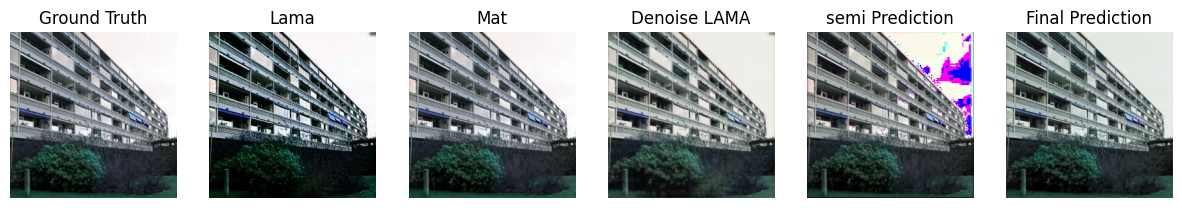

In [ ]:
denoising_model.to("cpu")
denoising_model.eval()
lama2 = denoising_model_lama(lama.unsqueeze(0).to(torch.float).permute(0,3,1,2)).squeeze()

plt.figure(figsize=(15,15))
plt.subplot(1,6,1)
plt.imshow((gt/255).detach().numpy())
plt.axis("off")
plt.title("Ground Truth")

plt.subplot(1,6,2)
plt.axis("off")
plt.imshow(lama.detach().numpy())
plt.title("Lama")

plt.subplot(1,6,3)
plt.axis("off")
plt.imshow(mat.detach().numpy())
plt.title("Mat")

plt.subplot(1,6,4)
plt.axis("off")
plt.imshow(lama2.permute(1,2,0).detach().numpy())
plt.title("Denoise LAMA")

plt.subplot(1,6,5)
plt.axis("off")
plt.imshow((pred).to(torch.uint8).permute(1,2,0).detach().numpy())
plt.title("semi Prediction")

plt.subplot(1,6,6)
plt.axis("off")
plt.imshow((denoising_model(pred.unsqueeze(0))*255).to(torch.uint8).squeeze().permute(1,2,0).detach().numpy())
plt.title("Final Prediction")

In [ ]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
out = ssim(pred.unsqueeze(0).to(torch.float), gt.permute(2,0,1).unsqueeze(0).to(torch.float)).item()
out

0.9920491576194763

In [ ]:
denoising_model(pred)*255

tensor([[[1.3850e+02, 2.4846e-19, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.5458e-19, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [4.6304e-34, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.5913e-25, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [5.9737e-22, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [5.7441e-16, 9.1165e-33, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 4.0184e-31]],

        [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.000

In [ ]:
# saving the final model
torch.save(model, "bagging_lama_mat_zero_dce_model.pth")

In [ ]:
torch.save(denoising_model, "best_final_denoiser_10epochs.pth")

In [ ]:
device = 'cuda'

In [ ]:
!pip install -q loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.4 MB/s eta 0:00:00


In [ ]:

from loguru import logger

logger.add("app.log")
logger.info("This will be logged to the file.")


2024-10-02 15:33:15.719 | INFO     | __main__:<cell line: 4>:4 - This will be logged to the file.


In [ ]:
model = torch.load("best_unet_with_denois_1500.pth")
denoising_model = torch.load('best_final_denoising_model_1500.pth')
denoising_model_lama = torch.load("lama_denoising_model_10_1500.pth")


<ipython-input-21-9e7c7afb2496>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("best_unet_with_denois_1500.pth")
<ipython-input-21-9e7c7afb2496>:2: Futu

In [ ]:
device = 'cuda' if torch.cuda.is_available else "cpu"

In [1]:
# finally evaluating the thing
import lpips
from tqdm import tqdm
import numpy as np
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torchmetrics.image.fid import FrechetInceptionDistance
import os
import torch
from torchvision.utils import save_image
denoising_model.to(device)
denoising_model_lama.to(device)
model.to(device)

final_list_0 = []
final_list_1 = []
final_list_2 = []
final_list_3 = []
final_list_4 = []
def eval_model(model_, device, test_dataloader, out_dir):

    metric_fn = lpips.LPIPS(net='alex').to(device)

    # model = HINT(experiment=args.experiment) #calling a model
    model_ = model_.to(device) #puting in gpu
    # model.load_state_dict(torch.load(args.checkpoint_path, map_location=device)) #loading weights

    #get dataloader
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    # ssim_metric += ssim(image_reconstructed, gt_image).item()
    fid = FrechetInceptionDistance().to(device)
    fid_final = FrechetInceptionDistance().to(device)

    metric = 0
    ssim_metric = 0
    fid_metric = 0
    metric_list = []
    ssim_metric_list = []
    fid_metric_list = []

    # DCE_net = enhance_net_nopool().to(device)
    # DCE_net.load_state_dict(torch.load('Zero-DCE/Zero-DCE_code/snapshots/Epoch99.pth'))
    model_.eval()
    # DCE_net.eval()

    if not os.path.exists(out_dir):
        # Create a new directory because it does not exist
        os.makedirs(out_dir)

    with tqdm(total=len(test_dataloader), unit_scale=True, postfix={'lpips':0.0,'ssim':0.0, 'fid':0.0}, ncols=150) as pbar:
        for i, (img, lama, mat) in enumerate(test_dataloader):
            img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)
            gt_image = img

            with torch.no_grad():
                lama = denoising_model_lama(lama)
                image_reconstructed = denoising_model(model_(lama, mat))*255.0 # i need to do /255.0
                # the below lines are for using ZERO-DCE
                # _,image_reconstructed,_ = DCE_net(image_reconstructed/255.0)
                # image_reconstructed = image_reconstructed*255

            for j in range(image_reconstructed.shape[0]):
                x = image_reconstructed
                save_image(x[j], out_dir+'/'+ str((2*i)+j) + ".jpg" )


            ssim_metric += ssim((image_reconstructed/255.0), (img/255.0)).item()
            fid.update(torch.tensor(image_reconstructed, dtype=torch.uint8), real = False)
            fid.update(torch.tensor(gt_image, dtype=torch.uint8), real = True)
            fid_metric += fid.compute().item()

            fid_final.update(torch.tensor(image_reconstructed, dtype=torch.uint8), real = False)
            fid_final.update(torch.tensor(gt_image, dtype=torch.uint8), real = True)

            metric += torch.mean(metric_fn(gt_image, image_reconstructed)).item()
            metric_list.append(torch.mean(metric_fn(gt_image, image_reconstructed)).item())
            ssim_metric_list.append(ssim((image_reconstructed/255.0),( gt_image/255.0)).item())
            fid_metric_list.append(fid.compute().item())

            s = ssim(image_reconstructed, gt_image).item()
            if s < 0.6:
              final_list_0.append(img)
              final_list_1.append(lama)
              final_list_2.append(mat )
              final_list_3.append(s)
              final_list_4.append(image_reconstructed)


            pbar.set_postfix({'lpips':metric/(i+1), 'ssim':ssim_metric/(i+1), 'fid' : fid_metric/(i+1)})
            pbar.update(1)

    print('\nLPIPS mean:', np.mean(metric_list))
    print('LPIPS std:', np.std(metric_list))
    print('ssim mean:', np.mean(ssim_metric_list))
    print('ssim std:', np.std(ssim_metric_list))
    print('fid mean:', np.mean(fid_metric_list))
    print('fid std:', np.std(fid_metric_list))
    print('fid final mean:', fid_final.compute().item())

    logger.info(f'LPIPS mean: {np.mean(metric_list)}')
    logger.info(f'LPIPS std: {np.std(metric_list)}')
    logger.info(f'ssim mean: {np.mean(ssim_metric_list)}')
    logger.info(f'ssim std: {np.std(ssim_metric_list)}')
    logger.info(f'fid mean: {np.mean(fid_metric_list)}')
    logger.info(f'fid std: {np.std(fid_metric_list)}')
    logger.info(f'fid final mean:', fid_final.compute().item())

    logger.info(f'LPIPS: {metric_list}')
    logger.info(f'ssim: {ssim_metric_list}')
    logger.info(f'fid: {fid_metric_list}')

    return metric_list, ssim_metric_list, fid_metric_list

# m = EnsembleModel()
# model2 = torch.load("bagging_lama_mat_model.pth")
# model2 = m.load_state_dict(ldict)

device = 'cuda' if torch.cuda.is_available else "cpu"
metric_list, ssim_metric_list, fid_metric_list = eval_model(model, device, dataloader, "outputs")

ModuleNotFoundError: No module named 'lpips'

In [ ]:
fid.compute()

NameError: name 'fid' is not defined

In [ ]:
np.mean(fid_metric_list)

8.133228079686692

In [ ]:
min(final_list_3)

-0.06728321313858032

In [ ]:
ind = final_list_3.index(min(final_list_3))
img = final_list_0[ind]
lama = final_list_1[ind]
mat = final_list_2[ind]
reco = final_list_4[ind]

# plt.imshow(img.permute(1,2,0).cpu().detach().numpy())

In [ ]:
img[0].dtype, reco[0].dtype

(torch.float32, torch.float32)

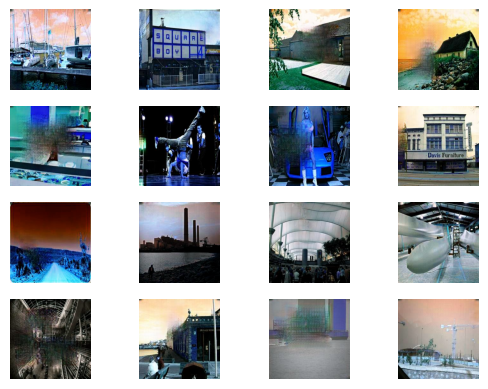

In [ ]:
# exploringg some data
z = next(iter(train_dataloader))

for i in range (16):
  plt.subplot(4,4,i+1)
  plt.axis("off")
  plt.imshow(z[1][i].to(torch.uint8).detach().numpy())

In [ ]:
z[0].dtype

torch.uint8

In [ ]:
z[0].dtype

torch.float32

In [ ]:
reco[0]

tensor([[[213.2049, 219.0001, 223.2276,  ..., 229.7455, 218.6306, 207.7406],
         [219.4811, 236.2220, 236.8063,  ..., 222.0527, 194.5364, 186.6219],
         [226.3889, 241.0398, 231.9200,  ..., 234.1431, 229.1865, 230.6421],
         ...,
         [ 64.4689,  43.8676,  30.5183,  ..., 167.7495, 228.4037, 222.8840],
         [ 55.2963,  45.6254,  48.4555,  ..., 181.0312, 237.8358, 206.4635],
         [ 70.7714,  91.1769, 125.5438,  ..., 147.6262, 153.8800, 104.2692]],

        [[174.6280, 224.7007, 231.0247,  ..., 226.7973, 209.6270, 198.0153],
         [225.0707, 235.1120, 237.0002,  ..., 234.8243, 208.6203, 208.2171],
         [223.1283, 238.5080, 228.6041,  ..., 235.3181, 230.9256, 233.8371],
         ...,
         [ 59.0299,  46.0224,  29.8571,  ..., 166.0350, 231.5663, 224.1427],
         [ 49.3685,  48.5255,  46.6778,  ..., 167.9712, 237.0643, 209.8403],
         [ 89.3713,  88.4819, 120.0458,  ..., 121.8262, 156.8248, 132.7534]],

        [[188.0788, 210.7455, 232.3617,  ...

In [ ]:
img[0]

tensor([[[252., 252., 252.,  ..., 255., 255., 255.],
         [252., 252., 252.,  ..., 255., 255., 255.],
         [251., 251., 251.,  ..., 255., 255., 255.],
         ...,
         [ 63.,  48.,  38.,  ..., 163., 251., 251.],
         [ 59.,  48.,  56.,  ..., 164., 251., 248.],
         [ 68.,  86., 134.,  ..., 163., 251., 244.]],

        [[254., 254., 254.,  ..., 255., 255., 255.],
         [254., 254., 254.,  ..., 255., 255., 255.],
         [253., 253., 253.,  ..., 255., 255., 255.],
         ...,
         [ 68.,  53.,  43.,  ..., 168., 255., 255.],
         [ 64.,  53.,  61.,  ..., 169., 255., 253.],
         [ 73.,  91., 139.,  ..., 168., 255., 249.]],

        [[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [254., 254., 254.,  ..., 255., 255., 255.],
         ...,
         [ 69.,  54.,  44.,  ..., 169., 255., 255.],
         [ 65.,  54.,  62.,  ..., 170., 255., 252.],
         [ 74.,  92., 140.,  ..., 169., 255., 248.]]]

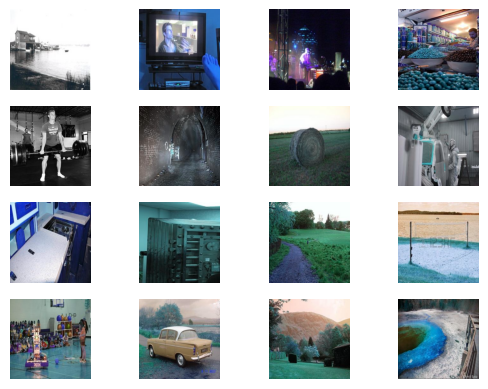

In [ ]:
# exploringg some data
z = img

for i in range (16):
  plt.subplot(4,4,i+1)
  plt.axis("off")
  plt.imshow((z[i]).to(torch.uint8).cpu().permute(1,2,0).detach().numpy())

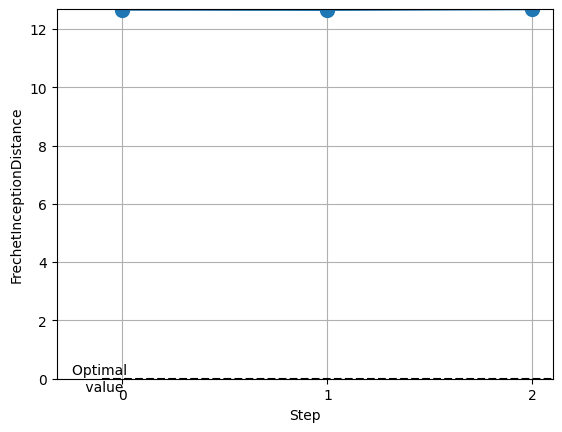

In [ ]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
imgs_dist1 = lambda: torch.randint(0, 200, (100, 3, 299, 299), dtype=torch.uint8)
imgs_dist2 = lambda: torch.randint(100, 255, (100, 3, 299, 299), dtype=torch.uint8)
metric_ = FrechetInceptionDistance(feature=64)
values = [ ]
for _ in range(3):
    metric_.update(imgs_dist1(), real=True)
    metric_.update(imgs_dist2(), real=False)
    values.append(metric_.compute())
    metric_.reset()
fig_, ax_ = metric_.plot(values)

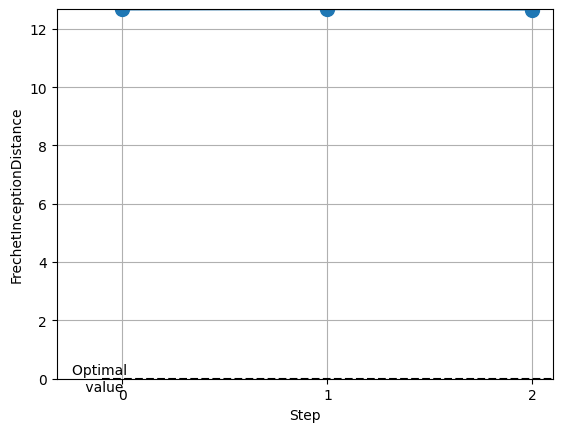

In [ ]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
imgs_dist1 = lambda: torch.randint(0, 200, (100, 3, 299, 299), dtype=torch.uint8)
imgs_dist2 = lambda: torch.randint(100, 255, (100, 3, 299, 299), dtype=torch.uint8)
metric_ = FrechetInceptionDistance(feature=64)
values = [ ]
for _ in range(3):
    metric_.update(imgs_dist1(), real=True)
    metric_.update(imgs_dist2(), real=False)
    values.append(metric_.compute())
    # metric_.reset()
fig_, ax_ = metric_.plot(values)

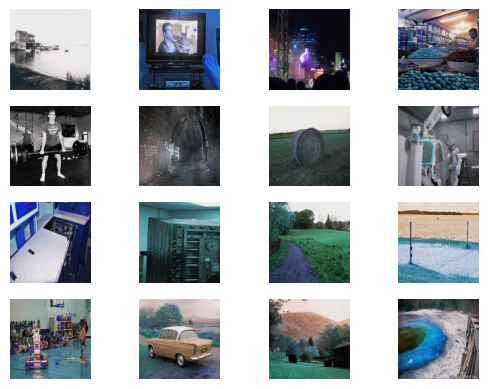

In [ ]:
# exploringg some data
z = reco

for i in range (16):
  plt.subplot(4,4,i+1)
  plt.axis("off")
  plt.imshow((z[i]).to(torch.uint8).cpu().permute(1,2,0).detach().numpy())

In [ ]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
out = ssim((reco/255.0).cpu(), (img/255.0).cpu()).item()
out

0.9739878177642822

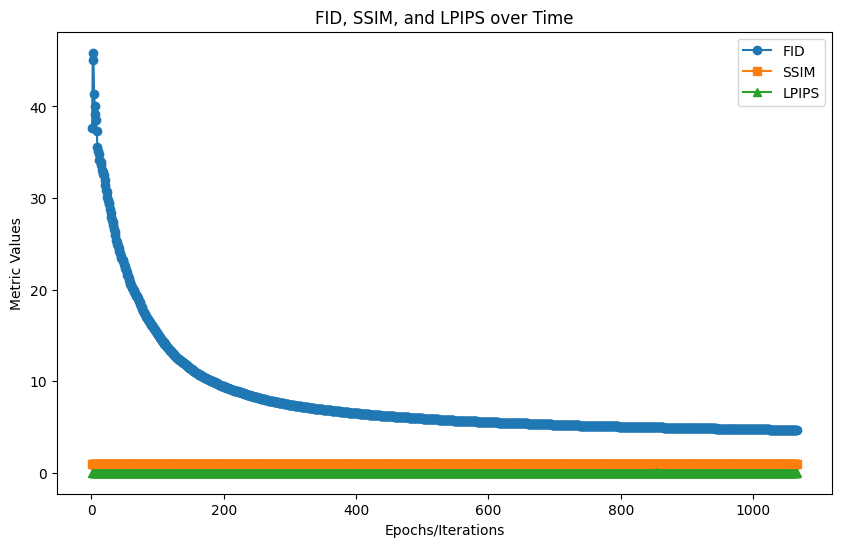

In [ ]:
# plotting the losses
import matplotlib.pyplot as plt

# Example data
fid_values = fid_metric_list
ssim_values = ssim_metric_list
lpips_values = metric_list

# X-axis values (e.g., epochs or iteration numbers)
x_values = list(range(1, len(fid_values) + 1))

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(x_values, fid_values, label='FID', marker='o')

# Plot SSIM values
plt.plot(x_values, ssim_values, label='SSIM', marker='s')

# Plot LPIPS values
plt.plot(x_values, lpips_values, label='LPIPS', marker='^')

# Add labels and title
plt.xlabel('Epochs/Iterations')
plt.ylabel('Metric Values')
plt.title('FID, SSIM, and LPIPS over Time')

# Add a legend
plt.legend()

# Show the plot
plt.show()


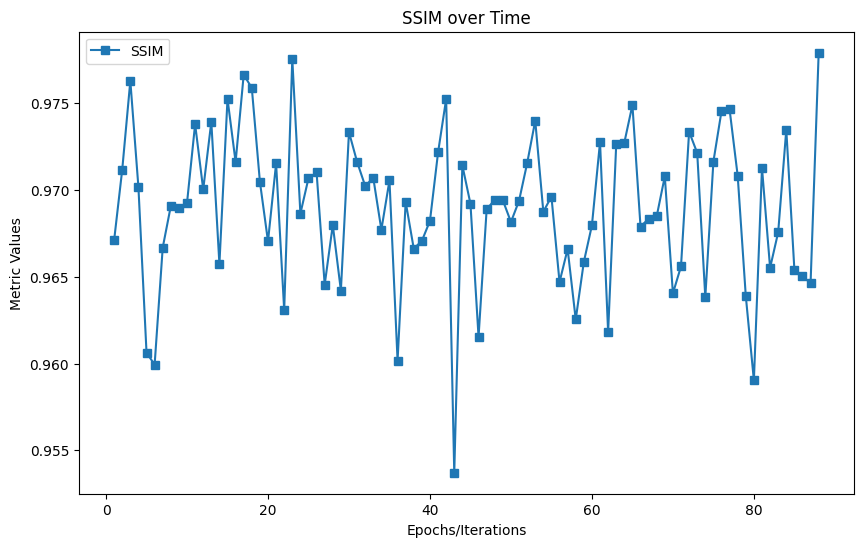

In [ ]:
# plotting the losses
import matplotlib.pyplot as plt

# Example data
ssim_values = ssim_metric_list

# X-axis values (e.g., epochs or iteration numbers)
x_values = list(range(1, len(ssim_values) + 1))

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot SSIM values
plt.plot(x_values, ssim_values, label='SSIM', marker='s')

# Add labels and title
plt.xlabel('Epochs/Iterations')
plt.ylabel('Metric Values')
plt.title('SSIM over Time')

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
# for plotting the imgs
from zero_model import enhance_net_nopool

model_ =  torch.load("bagging_lama_mat_model.pth")
device = "cuda"
model_.to(device)
DCE_net = enhance_net_nopool().to(device)
DCE_net.load_state_dict(torch.load('Zero-DCE/Zero-DCE_code/snapshots/Epoch99.pth'))
model_.eval()
DCE_net.eval()

for i, (img, lama, mat) in enumerate(test_dataloader):
        img, lama, mat =  img.permute(0,3,1,2).to(torch.float).to(device), lama.to(torch.float).permute(0,3,1,2).to(device), mat.to(torch.float).permute(0,3,1,2).to(device)
        gt_image = img
        image_reconstructed = model_(lama, mat) # i need to do /255.0
        _,image_reconstructed2,_ = DCE_net(image_reconstructed/255.0)
        break

        # image_reconstructed = image_reconstructed*255

In [ ]:
num = 5
plt.figure(figsize=(10,10))
plt.subplot(1,5,1)
plt.imshow(img[num].to(torch.uint8).cpu().permute(1,2,0).detach().numpy())
plt.axis("off")
plt.title("Ground Truth")

plt.subplot(1,5,2)
plt.axis("off")
plt.imshow(lama[num].cpu().to(torch.uint8).permute(1,2,0).detach().numpy())
plt.title("Lama")

plt.subplot(1,5,3)
plt.axis("off")
plt.imshow(mat[num].cpu().to(torch.uint8).permute(1,2,0).detach().numpy())
plt.title("Mat")

plt.subplot(1,5,4)
plt.axis("off")
plt.imshow(image_reconstructed[num].cpu().to(torch.uint8).permute(1,2,0).detach().numpy())
plt.title("No ZERO-DCE")

plt.subplot(1,5,5)
plt.axis("off")
plt.imshow((image_reconstructed2[num] * 255).cpu().to(torch.uint8).permute(1,2,0).detach().numpy())
plt.title("With ZERO-DCE")

#COLOR CORRECTION

In [ ]:
# so till now the img is quite good the only thing needed is color correction
# 1. using SSIM LOSS
# 2. Color correction
# 3. Img harmonization
# 4.

In [ ]:
!pip install pytorch_ssim

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def gaussian_window(window_size, sigma):
    """Generates a 1D Gaussian window."""
    gauss = torch.Tensor([np.exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    """Creates a 2D Gaussian window for each channel."""
    _1D_window = gaussian_window(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim(img1, img2, window_size=11, size_average=True, data_range=1):
    """Calculates SSIM between two images."""
    # Ensure both images are 4D tensors (N, C, H, W) and have the same shape
    if img1.shape != img2.shape:
        raise ValueError("Input images must have the same dimensions.")

    _, channel, _, _ = img1.size()

    # Create the Gaussian window
    window = create_window(window_size, channel).to(img1.device)

    # Compute the mean (mu) for both images
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    # Compute the variance (sigma) and covariance
    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    # Constants to stabilize the division when the denominator is small
    C1 = (0.01 * data_range) ** 2
    C2 = (0.03 * data_range) ** 2

    # Compute the SSIM map
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    # Return the mean SSIM value
    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def combined_loss(output, target, alpha=0.5):
    # Ensure that the input tensors are float and 4D (N, C, H, W)
    if output.ndimension() != 4 or target.ndimension() != 4:
        raise ValueError("Expected 4D tensors for output and target with shape (N, C, H, W)")

    if output.dtype != torch.float32 or target.dtype != torch.float32:
        output = output.float()
        target = target.float()

    # SSIM loss
    ssim_loss = 1 - ssim(output, target)

    # L1 loss (pixel-wise difference)
    l1_loss = F.l1_loss(output, target)

    # Combine SSIM and L1 loss, with a weighting factor alpha
    combined = alpha * ssim_loss + (1 - alpha) * l1_loss

    return combined



tensor(0.0060)


In [ ]:
gt.shape, pred.shape

(torch.Size([256, 256, 3]), torch.Size([3, 256, 256]))

In [ ]:
ssim(pred.unsqueeze(0).to(torch.float), gt.permute(2,0,1).unsqueeze(0).to(torch.float))

tensor(0.9967, grad_fn=<MeanBackward0>)

In [ ]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
out = ssim(pred.unsqueeze(0).to(torch.float), gt.permute(2,0,1).unsqueeze(0).to(torch.float)).item()
out

0.9946113228797913

In [ ]:
combined_loss

In [ ]:
from ColorCorrectionML import ColorCorrectionML
import cv2

img = cv2.imread('Images/img2.png')

cc = ColorCorrectionML(img, chart='Classic', illuminant='D50')

method = 'pls' # 'linear', 'lstsq', 'pls'
# for linear regression, least square regression, and partial least square regression respectively
show = True

kwargs = {
    'method': method,
    'degree': 3, # degree of polynomial
    'interactions_only': False, # only interactions terms,
    'ncomp': 10, # number of components for PLS only
    'max_iter': 5000, # max iterations for PLS only
    'white_balance_mtd': 0 # 0: no white balance, 1: learningBasedWB, 2: simpleWB, 3: grayWorldWB,
    }

M, patch_size = cc.compute_correction(
    show=show,
    **kwargs
)


# resize img by 2
# img = cv2.resize(img, (0,0), fx=0.3, fy=0.3, interpolation=cv2.INTER_AREA)

img_corr = cc.correct_img(img, show=True)
# img_corr = cc.Parallel_correct_img(img, chunks_=50000, show=True)